# 频率分析 (4)：非谐性频率矫正 VPT2

在本文档中，我们将会讨论非谐性频率矫正模型 VPT2。

在量化计算中，通常分子振动的频率通过 Hessian 矩阵给出。但我们也知道，Hessian 矩阵是能量对原子核坐标的两次导数；以这种方式求得的频率，相当于求取抛物线势函数的频率。但真实的势函数并非抛物线 (譬如 Morse、L-J 势函数等)，因此真实的频率会与 Hessian 矩阵所得到的值有少许区别。这也会影响到热力学矫正中，频率配分函数所产生的贡献值。

为了获得更真实的分子振动信息，那么就需要求解 Hamiltonian 受分子振动微扰后的本征波函数，并进而进行分析。近似的做法可以是微扰理论的矫正。这篇文档是其中一种近似方法，称为 Vibrational Perturbation Theory to the Second-Order (VPT2)。

我们主要会依据 V. Barone [^Barone.JCP.2005] 所提供的算法与公式进行实现。我们不对公式与其正确性作推演与检查。我们主要与 Gaussian 16 rev. B01 的结果作参照，但不会完全相同。

:::{note}

在 4 Core CPU 上完整执行本文档需要大约 5-10 分钟。

:::

::: {warning}

我们在本文档中使用处于非平衡构型的非对称的氨分子。

- **频率分析没有物理意义**：频率分析原则上一定要处于平衡构型；特殊的情况会是过渡态。除此之外的情况，频率分析都没有物理意义。需要先优化到稳定的构型再进行分析。
- **不考察对称性**：对于对称的分子，有可能会产生简并的频率。在一些情况下，简并会产生数值上的奇点。非简并的分子不太容易产生奇点，分析相对容易。
- **非线性分子**：很多时候，线性与非线性分子需要分别使用不同的方法分析。我们只考虑非线性分子，即 $3N-6$ 型分子。

:::

:::{danger}

若本文档有幸 (或不幸) 能帮助到读者，读者也需要知道**这份文档的程序实现未必正确！**

本文档所用于计算的体系比较特别 (有虚频的氨、能量最低结构的乙醛)，**无法保证可以应用到其它的分子**。

同时，**Gaussian 的不同版本有不同的 bug 和使用技巧** (当然完全可能是我的错误，但这应由读者去判断与负责)。我们会在具体的位置，给出各个版本存在潜在问题的情况；并且可能的话，会给出如何重复出 Gaussian 的结果。对于输入卡 {download}`anharm.gjf` 我们所考察的 Gaussian 版本有 16 rev. B01 {download}`anharm-G16B01.log`, 09 rev. D01 {download}`anharm-G09D01.log`, 09 rev. C01 {download}`anharm-G09C01.log`。

读者特别需要注意在作性质计算时，**大多数时候我们采用 Eckart Orientation**。

由于当前的 VPT2 理论本身就不适合用于小分子以外的计算 (容易由于频率共振而给出非常离谱的非谐矫正值)，因此即使看起来这里给出的做法似乎适合大分子，并且程序也看起来不会报错，但**必须要慎用当前文档所实现的 VPT2**。VPT2 有不止一种应用方式；Gaussian 也实现了一些变种，可以一定程度上解决共振效应，这是本文档我完全无法处理的。

:::

VPT2 分析会稍微复杂一些。我们在这里尽管会与 Gaussian 16 的结果作对照，但所有量化计算都会在 PySCF 进行。为此我们需要对 Hessian 矩阵作基础的 [频率分析](freq_1.ipynb)，并且需要进行 [数值导数](https://py-xdh.readthedocs.io/zh_CN/latest/numdiff/nuc_grad.html)；这两个功能分别实现在 {download}`freqanal.py` 与 {download}`deriv_numerical.py` 中。

In [1]:
%matplotlib notebook

from freqanal import FreqAnal
from deriv_numerical import NumericDiff, NucCoordDerivGenerator

import itertools
import numpy as np
from matplotlib import pyplot as plt
from opt_einsum import contract as einsum
from pyscf import gto, scf, hessian, lib, data

np.set_printoptions(6, linewidth=150, suppress=True)

我们也需要进行单位换算。这在先前的若干文档中已经有所使用。

In [2]:
from scipy.constants import physical_constants
# https://docs.scipy.org/doc/scipy/reference/constants.html
E_h = physical_constants["Hartree energy"][0]
a_0 = physical_constants["Bohr radius"][0]
N_A = physical_constants["Avogadro constant"][0]
c_0 = physical_constants["speed of light in vacuum"][0]
e_c = physical_constants["elementary charge"][0]
e_0 = physical_constants["electric constant"][0]
F = physical_constants["Faraday constant"][0]
k_B = physical_constants["Boltzmann constant"][0]
R = physical_constants["molar gas constant"][0]
h = physical_constants["Planck constant"][0]
hbar = physical_constants["reduced Planck constant"][0]
amu = physical_constants["atomic mass constant"][0]

除了文末的红外光谱绘制，我们使用的分子是不具有对称性的氨分子，基组 STO-3G。

In [3]:
mol = gto.Mole(atom="""
N  0.000000    0.000000    0.000000
H  0.000000    0.000000    0.940000
H  1.006874    0.000000   -0.260395
H -1.037114   -0.277894   -0.640054
""", basis="STO-3G", verbose=0).build()

## 数值三阶与四阶核坐标导数

### 二阶导数回顾与频率数值

:::{admonition} 记号定义

**角标定义**

- $A, B$：原子核标号；
- $\alpha, \beta, \gamma$：三维坐标的取向 (即可以取 $x, y, z$，也可能取转动惯量主轴，本文档多数时间选择后者)；
- $i, j, k$：简振模式的编号。

**物理量定义**

- $A_\alpha$：原子核 $A$ 的坐标三维分量 $\alpha$；
- $Q_i$：一单位的简振模式 $i$；
- $Q_{A_\alpha, i}$：简振模式转换矩阵，即 $i$ 在原子坐标分量 $A_\alpha$ 的分量值。

需要注意到，这些记号的定义与量化程序中的定义，也与之前文档的定义是冲突或不同的。读者需要注意记号的差别。

:::

我们知道，Hessian 矩阵是频率分析的必要矩阵，它即是二阶核坐标导数，及

$$
\Phi_{A_\alpha B_\beta} = \frac{\partial^2 E}{\partial A_t \partial B_s}
$$

在原子坐标分量表示下，这应当是一个 $(A_\alpha, B_\beta): (3 n_\mathrm{atm}, 3 n_\mathrm{atm})$ 的矩阵。尽管依据程序不同，也可能是张量——在 PySCF 中，Hessian 的默认输出是 $(A, B, \alpha, \beta): (n_\mathrm{atm}, n_\mathrm{atm}, 3, 3)$ 维度的张量，但张量的大小与 $(A_\alpha, B_\beta)$ 实际上一致，经过转置两者就能相同。

In [4]:
natm = mol.natm
nhess = natm * 3

mf = scf.RHF(mol).run()
mf_hess = mf.Hessian().run()

我们也需要定义频率分析的实例 `fa`，其变量名是 `FreqAnal` 的首字母，与♂fa 乐器♂无关。下面的 code cell 输出的是以 $\mathrm{cm^{-1}}$ 为简振振动频率 $\omega_i$。

如果要与 Gaussian 的结果有更好的印证，原子质量需要取与 Gaussian 相同的值，而不太适合用整数值。因此，这里没有用 PySCF 自带的 `mol.atom_mass_list`，而是使用一个函数 `get_atom_mass_list` 来解决问题。

In [5]:
def get_atom_mass_list(mol):
    d = {1: 1.00782504, 6: 12., 7: 14.0030740, 8: 15.9949146}
    return np.array([d[m] for m in mol.atom_charges()])

In [6]:
fa = FreqAnal()
fa.mol_weights = get_atom_mass_list(mol)
fa.mol_coords = mol.atom_coords()
fa.natm = mol.natm
fa.mol_hess = mf_hess.de.swapaxes(1, 2)
nvib = fa.freq.size
fa.freq

array([-969.746082, 1680.3876  , 1931.786797, 2059.643873, 3874.822068, 5095.777567])

:::{admonition} 记号定义

我们之后会经常作单位换算与量纲分析，因此这里尽量将目前与将来需要的物理量与量纲列出：

- $Q_i$ 简振模式，单位 $\mathrm{Bohr \ amu^{1/2}}$；
- $Q_{A_\alpha i}$ 简振模量到分子坐标表象的转换矩阵，单位 $\mathrm{amu^{-1/2}}$，程序调用 `fa.q`；
- $Q_{A_\alpha i}^\mathrm{norm}$ 归一化的简振模量转换矩阵，无量纲，程序调用 `fa.qnorm`；
- $\omega_i$ 简振振动频率，单位 $\mathrm{cm^{-1}}$，程序调用 `fa.freq`；
- $\nu_i$ 非谐振动频率，单位 $\mathrm{cm^{-1}}$；
- $\lambda_i$ 二阶力常数，单位 $\mathrm{\mathit{E}_h \ Bohr^{-2} \ amu^{-1}}$；
- $\Phi_{A_\alpha B_\beta}$ 坐标表示的 Hessian 矩阵，单位 $\mathrm{\mathit{E}_h \ Bohr^{-2}}$；
- $\Phi_{ij}$ 简振表示的 Hessian 矩阵，单位 $\mathrm{\mathit{E}_h \ Bohr^{-2} \ amu^{-1}}$；
- $\Phi_{ijk}$ 简振表示的三阶导数，单位 $\mathrm{\mathit{E}_h \ Bohr^{-3} \ amu^{-3/2}}$；
- $\Phi_{ijkl}$ 简振表示的四阶导数，单位 $\mathrm{\mathit{E}_h \ Bohr^{-4} \ amu^{-2}}$；
- $I_\alpha$ 转动惯量，单位 $\mathrm{amu \ Bohr^{2}}$；
- $\varpi_\alpha$ 转动常数，单位 $\mathrm{cm^{-1}}$；
- $\zeta_{ij}^\alpha$ Coriolis 耦合常数，无量纲；
- $\theta_i (T)$ 温度矫正系数，无量纲；
- $\boldsymbol{\mu}$ 偶极矩，单位 $\mathrm{Debye}$；

:::

为了后文的便利，我们也会经常使用在简振模式表示下的 Hessian 矩阵：

$$
\Phi_{ij} = \frac{\partial^2 E}{\partial Q_i \partial Q_j}
$$

从定义上，简振模式是分子振动的 Hessian 矩阵的本征模式，因此 $\Phi_{ij}$ 实际上是对角矩阵 $\lambda_i \delta_{ij}$。其中，$\lambda_i$ 是简振模式 $i$ 的振动强度。坐标表示与简振表示的换算关系是

$$
\Phi_{ij} = \sum_{A_\alpha B_\beta} Q_{A_\alpha i} \Phi_{A_\alpha B_\beta} Q_{B_\beta j}
$$

我们用 `deriv_2` 表示 $\Phi_{ij}$。

In [7]:
deriv_2 = einsum("Pi, PQ, Qj -> ij", fa.q, fa.mol_hess.reshape(nhess, nhess), fa.q)
deriv_2

array([[-0.035588, -0.      ,  0.      ,  0.      , -0.      , -0.      ],
       [-0.      ,  0.106859,  0.      , -0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.141224, -0.      ,  0.      ,  0.      ],
       [ 0.      , -0.      , -0.      ,  0.160537, -0.      , -0.      ],
       [ 0.      ,  0.      , -0.      , -0.      ,  0.568192, -0.      ],
       [-0.      , -0.      , -0.      , -0.      , -0.      ,  0.982681]])

我们注意到这是一个对称矩阵。实际上，简振模式从定义上就是在 Hessian 矩阵去除了平动、转动贡献之后的本征振动模式；因此，在简振模式表示下的 Hessian 矩阵自然应当是对角化的。其对角元我们之后也经常用到，因此以 `lambd` $\lambda_i = \Phi_{ij} \delta_{ij}$ 表示，物理量上称为力常数。

In [8]:
lambd = deriv_2.diagonal()
lambd

array([-0.035588,  0.106859,  0.141224,  0.160537,  0.568192,  0.982681])

力常数 $\lambda_i$ 它与频率 $\omega_i$ 之间的关系是

$$
\omega_i = \frac{\sqrt{\lambda_i}}{2 \pi c_0} = \frac{1}{2 \pi c_0} \sqrt{\frac{k_i}{m}}, \quad \lambda = (2 \pi c_0 \omega_i)^2
$$

它与我们经常看到的另一个力常数 $k_i$ 不同。从量纲上，$\lambda_i$ 是 $\mathrm{[T]^{-2}}$。如果考虑到一些比较麻烦的单位换算，我们可以通过频率 $\omega_i$ 给出力常数 $\lambda_i$。

单位换算的原则如下。我们发现，对于等式左边的待求量完全是原子单位，但右边则完全是经过变动的 SI 单位制 (波数以 $\mathrm{cm^{-1}}$ 而非以 $\mathrm{m^{-1}}$ 表示)。我们以 SI 单位制作为中间单位，
- 对等式左边，$\lambda_i$ 的单位是 $\mathrm{\mathit{E}_h \ Bohr^{-2} \ amu^{-1}}$，我们要对应地除以这部分单位的 SI 转换；
- 对等式右边，$\omega_i$ 的单位是 $\mathrm{cm^{-1}}$，我们要乘以这部分的 SI 转换 ($100$)。

In [9]:
(
    (2 * np.pi * c_0 * fa.freq)**2        # equation
    / (E_h * a_0**-2 * amu**-1) * 100**2  # unit conversion
)

array([0.035588, 0.106859, 0.141224, 0.160537, 0.568192, 0.982681])

我们最后讨论一下简振模量矩阵 $Q_{A_\alpha i}$ 与其归一化形式 $Q_{A_\alpha i}^\mathrm{norm}$ 之间的关系。在 Gaussian 的输出中，我们一般只会看到 $Q_{A_\alpha i}^\mathrm{norm}$，它具有下述限制：

$$
\sum_{A_\alpha} (Q_{A_\alpha i}^\mathrm{norm})^2 = 1 , \ \forall i
$$

正因为这种归一化条件，$Q_{A_\alpha i}^\mathrm{norm}$ 实际上是没有量纲的。但我们以后一直要遇到与处理的简振模量，是所谓分子质量折合过的模量，其量纲是 $\mathrm{[M]^{-1/2}}$。它也可以从归一化的简振模量导出，其中 $m_\mathrm{A}$ 是 $A$ 原子的质量：

$$
Q_{A_\alpha i} = Q_{A_\alpha i}^\mathrm{norm} \left( \sum_{A_\alpha} \big( Q_{A_\alpha i}^\mathrm{norm} \sqrt{m_\mathrm{A}} \big)^2 \right)^{-1/2}
$$

In [10]:
np.allclose(fa.qnorm / np.linalg.norm(fa.qnorm * np.sqrt(np.repeat(get_atom_mass_list(mol), 3))[:, None], axis=0), fa.q)

True

### 数值三阶导数

我们以后一直会使用简振坐标表示下的能量导数；并且我们注意到简振模式的数量是 $3N-6$，比原子坐标分量的 $3N$ 数量要少一些。因此，在求取数值导数时，我们会希望使用简振模式作为实际被求导量。

我们需要的三阶导数量是

$$
\Phi_{ijk} = \frac{\partial^3 E}{\partial Q_i \partial Q_j \partial Q_k}
$$

但在求取数值导数时，我们可以选择一个量作为数值偏移量，譬如 $Q_k$；而剩下的量则是解析地计算。但我们也注意到，程序上默认给出的是原子坐标表示的 $\Phi_{A_\alpha B_\beta}$，还需要我们作转换得到 $\Phi_{ij}$。因此，数值导数的求取方法是

$$
\Phi_{ijk} = \sum_{A_\alpha B_\beta} Q_{A_\alpha i} Q_{B_\beta j} \Phi_{A_\alpha B_\beta k} = \sum_{A_\alpha B_\beta} Q_{A_\alpha i} Q_{B_\beta j} \frac{\Phi_{A_\alpha B_\beta} (\delta Q_k) - \Phi_{A_\alpha B_\beta} (-\delta Q_k)}{2 \delta Q_k} 
$$

下面的程序就是以 $0.01 \ \mathrm{\mathring{A}} \ \mathrm{amu}^{1/2}$ 为偏移大小，求取对简振坐标导数的程序：

In [11]:
class ModeDerivGenerator(NucCoordDerivGenerator):

    def __init__(self, mol, mf_func, q, interval=3e-3):
        self.q = q
        super(ModeDerivGenerator, self).__init__(mol, mf_func, stencil=3, interval=interval)
    
    def init_objects(self):
        nmode = self.q.shape[1]
        self.objects = np.empty((nmode, 2), dtype=object)
    
    def perform_mf(self):
        natm = self.mol.natm
        nmode = self.q.shape[1]
        for nq, norm in enumerate(self.q.T):
            norm = norm.reshape(natm, 3)
            movelist = [(A, t, norm[A, t]) for A in range(natm) for t in range(3)]
            self.objects[nq, 1] = self.mf_func(self.move_mol(movelist))
            movelist = [(A, t, - norm[A, t]) for A in range(natm) for t in range(3)]
            self.objects[nq, 0] = self.mf_func(self.move_mol(movelist))

我们将 Hessian 对简振坐标的导数实例定为 `num_hess`：

In [12]:
num_hess = ModeDerivGenerator(mol, lambda mol: scf.RHF(mol).run().Hessian().run(), fa.q, interval=0.01)

使用 `NumericDiff` 直接求导的结果是 $\Phi_{A_\alpha B_\beta k}$。我们需要再对其进行转换再得到 $\Phi_{ijk}$ `deriv_3`：

In [13]:
tmp_3 = NumericDiff(num_hess, lambda mf: mf.de.swapaxes(1, 2).reshape(nhess, nhess)).derivative
deriv_3 = einsum("Ai, Bj, kAB -> ijk", fa.q, fa.q, tmp_3)

严格地来说，$\Phi_{ijk}$ 应当是具有六重对称性的张量。因此，我们还可以对其进行对称化，使得结果定性上更正确：

In [14]:
deriv_3 = 1/3 * (deriv_3 + deriv_3.transpose(1, 2, 0) + deriv_3.transpose(2, 0, 1))

### 数值四阶导数

我们通过三点差分的方法，给出了三阶导数。尽管我们无法求出全部的四阶导数，但利用刚才求取三阶导数的数据，我们可以求取 $\Phi_{ijkk}$ 形式的四阶导数：

$$
\Phi_{ijkk} = \frac{\partial^2}{\partial Q_k^2} \frac{\partial^2 E}{\partial Q_i \partial Q_j} = \frac{\Phi_{ij} (\delta Q_k) - 2 \Phi_{ij} (0) + \Phi_{ij} (-\delta Q_k)}{(\delta Q_k)^2}
$$

注意到利用现有的数据，我们只能求取 $\Phi_{ijkk}$，而不能求取更一般的 $\Phi_{ijkl}$。该张量也具有对称性；我们可以对 $i, j$ 角标进行对称化。我们将会用 `deriv_4` 表示 $\Phi_{ijkk}$，维度是 $(i, j, k)$

In [15]:
hess_gathered = np.array([[mf.de.swapaxes(1, 2).reshape(nhess, nhess) for mf in l] for l in num_hess.objects])
tmp_4 = einsum("ksAB, Ai, Bj -> skij", hess_gathered, fa.q, fa.q)
deriv_4 = (tmp_4[0] + tmp_4[1] - 2 * deriv_2) / (num_hess.interval**2)  # finite diff
deriv_4 = (deriv_4 + deriv_4.swapaxes(-1, -2)) / 2                      # symmetrize
deriv_4 = einsum("kij -> ijk", deriv_4)                                 # subscript transform

## 非谐频率矫正

在求取频率矫正前，我们需要先获得矩阵 $\xi_{ij}$ `xmat`。该矩阵与频率相同单位，即 $\mathrm{cm}^{-1}$。这里的公式主要参考 Barone eq. (36-38)，但在与一些系数有关的问题上不太相同。该矩阵对非谐矫正后的频率至关重要。

### 四阶导数对 $\xi_{ij}$ 的贡献

若除开单位换算，四阶导数对矩阵 $\xi_{ij}$ 的贡献是

$$
\begin{align}
\xi_{ii} &\leftarrow \frac{\hbar}{2 \pi c_0} \frac{1}{16 \lambda_i} \Phi_{iiii} \\
\xi_{ij} &\leftarrow \frac{\hbar}{2 \pi c_0} \frac{1}{4 \sqrt{|\lambda_i \lambda_j|}} \Phi_{iijj} \quad (i \neq j)
\end{align}
$$

之所以表达式中需要引入绝对值，是因为我们同时处理实频与虚频。虚频下，$\lambda_i$ 小于零，无法开根号。依据 Miller, et al. [^Miller.CPL.1990] 的表达式，实际上对于有且仅有一个虚频的 $Q_i$，其对应的 $\xi_{ij}$ 也应当是虚数。当前的分子也恰好是有且仅有一个虚频，并且实际上虚数的 $\xi_{ij}$ 可以与虚数的 $\omega_i$ 相加得到非谐频率 $\nu_i$；因此就这种过渡态情形，在程序实现上，可以对虚频与实频一视同仁。

In [16]:
xmat_4 = np.zeros((nvib, nvib))
for i in range(nvib):
    xmat_4[i, i] = deriv_4[i,i,i] / (16 * lambd[i])
    for j in range(nvib):
        if i == j: continue
        xmat_4[i, j] = deriv_4[i,i,j] / (4 * np.sqrt(np.abs(lambd[i] * lambd[j])))
xmat_4 *= (hbar / (2 * np.pi * c_0)) * (a_0**-2 * amu**-1) / (100)
xmat_4

array([[ -59.929105,   17.359227,    2.022484,  -26.747814,  -89.778445, -133.911891],
       [  17.360842,   11.4939  ,   18.955104,   -6.407765,   -6.83072 , -112.008037],
       [   2.024055,   18.952477,    4.4002  ,   42.205352,  -50.906768,  -38.849444],
       [ -26.737152,   -6.40661 ,   42.197109,   45.874797,  -16.574222,   -5.321896],
       [ -89.725547,   -6.828563,  -50.876096,  -16.565645,   62.64625 ,    1.480829],
       [-133.825551, -111.932215,  -38.826908,   -5.319965,    1.480938,   70.703952]])

### 三阶导数对 $\xi_{ij}$ 的贡献

三阶导数对 $\xi_{ij}$ 的贡献核算相对复杂。我们首先处理对角线的贡献：

$$
\xi_{ii} \leftarrow - \frac{\hbar}{2 \pi c_0} \frac{1}{16 \lambda_i} \left( \frac{5}{3 \lambda_i} \Phi_{iii}^2 + \frac{8 \lambda_i - 3 \lambda_j}{\lambda_j (4 \lambda_i - \lambda_j)} \Phi_{iij}^2 \right)
$$

In [17]:
xmat_3 = np.zeros((nvib, nvib))

In [18]:
for i in range(nvib):
    xmat_3[i, i] -= deriv_3[i,i,i]**2 * 5 / (3 * lambd[i])
    for j in range(nvib):
        if i == j: continue
        xmat_3[i, i] -= deriv_3[i,i,j]**2 * (8 * lambd[i] - 3 * lambd[j]) / (lambd[j] * (4 * lambd[i] - lambd[j]))
    xmat_3[i, i] /= 16 * lambd[i]

随后处理非对角线的贡献 ($i \neq j$)：

$$
\begin{align}
\xi_{ij} &\leftarrow - \frac{\hbar}{2 \pi c_0} \frac{1}{4 \sqrt{|\lambda_i \lambda_j|}} \left( \frac{2}{4 \lambda_i - \lambda_j} \Phi_{iij}^2 + \frac{2}{4 \lambda_j - \lambda_i} \Phi_{ijj}^2 + \frac{\Phi_{iii} \Phi_{ijj}}{\lambda_i} + \frac{\Phi_{jjj} \Phi_{iij}}{\lambda_j} \right) \\
&\quad + \frac{\hbar}{2 \pi c_0} \frac{1}{4 \sqrt{|\lambda_i \lambda_j|}} \sum_{k \notin \{i, j\}} \left[ \frac{2 (\lambda_i + \lambda_j - \lambda_k)}{\Delta_{ijk}} \Phi_{ijk}^2 - \frac{\Phi_{iik} \Phi_{jjk}}{\lambda_k} \right]
\end{align}
$$

In [19]:
for i in range(nvib):
    for j in range(nvib):
        if i == j: continue
        xmat_3[i, j] -= deriv_3[i,i,j]**2 * 2 / (4 * lambd[i] - lambd[j])
        xmat_3[i, j] -= deriv_3[i,j,j]**2 * 2 / (4 * lambd[j] - lambd[i])
        xmat_3[i, j] -= deriv_3[i,i,i] * deriv_3[i,j,j] / lambd[i]
        xmat_3[i, j] -= deriv_3[j,j,j] * deriv_3[i,i,j] / lambd[j]
        for k in range(nvib):
            if len(set([i, j, k])) != 3: continue
            delta_ijk = lambd[i]**2 + lambd[j]**2 + lambd[k]**2 - 2 * (lambd[i]*lambd[j] + lambd[j]*lambd[k] + lambd[k]*lambd[i])
            xmat_3[i, j] += deriv_3[i,j,k]**2 * 2 * (lambd[i] + lambd[j] - lambd[k]) / delta_ijk
            xmat_3[i, j] -= deriv_3[i,i,k] * deriv_3[j,j,k] / lambd[k]
        xmat_3[i, j] /= 4 * np.sqrt(np.abs(lambd[i] * lambd[j]))

In [20]:
xmat_3 *= (hbar / (2 * np.pi * c_0)) * (a_0**-2 * amu**-1) / (100)
xmat_3

array([[   6.436059,  -17.659895,  -12.843587,  -17.730696,   49.859864,   86.717056],
       [ -17.659895,  -18.294258,  -35.959998,  -46.395273,    2.625465,   94.139235],
       [ -12.843587,  -35.959998,  -65.430162, -108.220206,  228.295265,   26.274758],
       [ -17.730696,  -46.395273, -108.220206, -115.728507,  -19.13443 ,   -3.494852],
       [  49.859864,    2.625465,  228.295265,  -19.13443 , -111.055075,  -10.265471],
       [  86.717056,   94.139235,   26.274758,   -3.494852,  -10.265471, -112.711441]])

### Coriolis 矫正对 $\xi_{ij}$ 的贡献

Coriolis 矫正的贡献方式是 (允许 $i = j$)

$$
\xi_{ij} \leftarrow \sum_\alpha \frac{\lambda_i + \lambda_j}{\sqrt{|\lambda_i \lambda_j|}} \varpi_\alpha (\zeta_{ij}^\alpha)^2
$$

这里引入了一些特殊的记号。被求和的角标 $\alpha$ 尽管是 $x, y, z$ 三个取向之一，但在求取 Coriolis 矫正贡献时，它必须是转动惯量主轴。

我们在通过 Hessian 矩阵得到分子振动频率时，需要去除转动的三个自由度贡献。那时我们已经计算过与转动有关的各种中间变量。$\varpi_\alpha$ `rot_wavenum` 是以 $\mathrm{cm^{-1}}$ 为单位的转动常数：

$$
\varpi_\alpha = \frac{h}{8 \pi^2 c_0 I_\alpha}
$$

In [21]:
rot_wavenum = h / (8 * np.pi**2 * c_0 * fa.rot_eig) * (a_0**-2 * amu**-1) / (100)
rot_wavenum

array([13.875725,  7.153573,  4.775983])

而 $\zeta_{ij}^\alpha$ `zeta` Coriolis 耦合常数通过下式进行计算 (Barone, eq (11)，维度 $(\alpha, i, j)$，无量纲)：

$$
\begin{align}
\zeta_{ij}^\alpha &= \sum_k (L_{A_\beta i} L_{A_\gamma j} - L_{A_\gamma i} L_{A_\beta j}) \\
L_{A_\alpha i} &= \sum_\beta Q_{A_\beta i} R_{\beta \alpha} \sqrt{m_A}
\end{align}
$$

其中，$R_{\beta \alpha}$ 转动的本征向量，无量纲。其本征值是转动惯量，这在 [频率分析 (1)](freq_1.ipynb) 中有所提及。同时，求取 $\zeta_{ij}^\alpha$ 时，其表达式的分量 $\alpha, \beta, \gamma$ 必须按照右手坐标系排序。

In [22]:
q_ = einsum("Aβi, βα, A -> Aαi", fa.q.reshape(natm, 3, nvib), fa.rot_vec, np.sqrt(get_atom_mass_list(mol)))
zeta_x = einsum("Ai, Aj -> ij", q_[:, 1, :], q_[:, 2, :]) - einsum("Ai, Aj -> ij", q_[:, 2, :], q_[:, 1, :])
zeta_y = einsum("Ai, Aj -> ij", q_[:, 2, :], q_[:, 0, :]) - einsum("Ai, Aj -> ij", q_[:, 0, :], q_[:, 2, :])
zeta_z = einsum("Ai, Aj -> ij", q_[:, 0, :], q_[:, 1, :]) - einsum("Ai, Aj -> ij", q_[:, 1, :], q_[:, 0, :])
zeta = np.array([zeta_x, zeta_y, zeta_z])

同时，转动本征向量还可以用来将分子旋转到转动主轴坐标系，且该坐标系的 $I_x < I_y < I_z$。该坐标系在 Gaussian 中称为 Eckart Orientation。我们可以输出该坐标系下以 Angstrom 为单位的分子构型。

In [23]:
fa.centered_coord @ fa.rot_vec * a_0 * 1e10

array([[ 0.003095, -0.002241, -0.016268],
       [ 0.384988,  0.851931,  0.073996],
       [ 0.805212, -0.657419,  0.078348],
       [-1.233207, -0.163374,  0.07369 ]])

至此，我们就可以将 Coriolis 矫正的贡献计算出来。

$$
\xi_{ij} \leftarrow \sum_\alpha \frac{\lambda_i + \lambda_j}{\sqrt{|\lambda_i \lambda_j|}} \varpi_\alpha (\zeta_{ij}^\alpha)^2
$$

In [24]:
xmat_coriol = np.zeros((nvib, nvib))
for i in range(nvib):
    for j in range(nvib):
        for ixyz in range(3):
            xmat_coriol[i, j] += zeta[ixyz, i, j]**2 * rot_wavenum[ixyz]
        xmat_coriol[i, j] *= (lambd[i] + lambd[j]) / np.sqrt(np.abs(lambd[i] * lambd[j]))
xmat_coriol

array([[-0.      ,  6.485503,  2.854787,  7.462297, 14.215879, 25.469408],
       [ 6.485503,  0.      ,  0.862218,  2.938909,  0.906227,  8.749904],
       [ 2.854787,  0.862218,  0.      ,  0.883756,  5.835533,  3.491808],
       [ 7.462297,  2.938909,  0.883756,  0.      ,  1.970819,  0.474133],
       [14.215879,  0.906227,  5.835533,  1.970819,  0.      ,  0.009302],
       [25.469408,  8.749904,  3.491808,  0.474133,  0.009302,  0.      ]])

:::{danger}

对于 Gaussian 09 rev. D01 及 C01，其输出的 Coriolis 贡献是错误的。其原因在于没有将分子坐标预先转置到 Eckart Orientation 下，而仍然在输入坐标下进行计算。将这种坐标与转动惯量主轴的转动频率作乘积没有意义。也因此，该版本的 Gaussian 实际上无法正确地输出频率的矫正；除非输入坐标与 Eckart Orientation 一致。

如果要重复该版本的结果，**对于当前的分子**，可以使用后面一个被折叠的 code cell 代码。

我们之前号称正确的实现方式，与 Gaussian 16 rev. B01 的结果应当一致。

:::

In [25]:
def xmat_coriol_G09():
    # -- What makes different --
    q_ = einsum("Aαi, A -> Aαi", fa.q.reshape(natm, 3, nvib), np.sqrt(get_atom_mass_list(mol)))
    rot_in_G09 = rot_wavenum[0], rot_wavenum[2], rot_wavenum[1]
    # -- The rest are merely the same --
    zeta = np.zeros((3, nvib, nvib))
    for α, β, γ in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]:
        zeta[α] = einsum("Ai, Aj -> ij", q_[:, β, :], q_[:, γ, :]) - einsum("Ai, Aj -> ij", q_[:, γ, :], q_[:, β, :])
    xmat_coriol = einsum("αij, α, ij -> ij", zeta**2, rot_in_G09, (lambd[:, None] + lambd[None, :]) / np.sqrt(np.abs(lambd[:, None] * lambd[None, :])))
    return xmat_coriol
xmat_coriol_G09()

array([[ 0.      ,  4.90998 ,  3.505416,  9.864751, 10.909095, 26.892735],
       [ 4.90998 ,  0.      ,  0.933722,  3.050355,  0.933074,  9.206211],
       [ 3.505416,  0.933722,  0.      ,  0.902214,  5.887021,  3.409958],
       [ 9.864751,  3.050355,  0.902214,  0.      ,  1.987215,  0.43257 ],
       [10.909095,  0.933074,  5.887021,  1.987215,  0.      ,  0.009969],
       [26.892735,  9.206211,  3.409958,  0.43257 ,  0.009969,  0.      ]])

In [26]:
! head -n 9725 anharm-G09C01.log | tail -n 10

 Coriolis contributions to Xmat 
                1             2             3             4             5 
      1  0.000000D+00
      2  0.268927D+02  0.000000D+00
      3  0.109091D+02  0.996906D-02  0.000000D+00
      4  0.986475D+01  0.432572D+00  0.198722D+01  0.000000D+00
      5  0.350541D+01  0.340996D+01  0.588702D+01  0.902213D+00  0.000000D+00
      6  0.490997D+01  0.920621D+01  0.933076D+00  0.305035D+01  0.933724D+00
                6 
      6  0.000000D+00


### 总 $\xi_{ij}$ 矩阵与非谐频率的导出

我们首先将四阶导数、三阶导数、Coriolis 的贡献相加，得到总 $\xi_{ij}$ 矩阵。

In [27]:
xmat = xmat_4 + xmat_3 + xmat_coriol
xmat

array([[-53.493046,   6.184835,  -7.966316, -37.016213, -25.702702, -21.725427],
       [  6.18645 ,  -6.800358, -16.142676, -49.864129,  -3.299028,  -9.118898],
       [ -7.964745, -16.145302, -61.029962, -65.131098, 183.22403 ,  -9.082879],
       [-37.005551, -49.862974, -65.139341, -69.85371 , -33.737833,  -8.342616],
       [-25.649804,  -3.296871, 183.254702, -33.729256, -48.408825,  -8.77534 ],
       [-21.639087,  -9.043076,  -9.060343,  -8.340685,  -8.775231, -42.007489]])

这可以与 Gaussian 的输出作比对。需要注意，**我们的结果与 Gaussian 并不完全一致**，且不仅是由于简振模式的排序不同所产生。这是由于 Fermi 共振所致，我们后面会提及。**我们的程序无法处理 Fermi 共振**，但 Gaussian 会有一些办法。

In [28]:
! head -n 14013 anharm-G16B01.log | tail -n 11

 Total Anharmonic X Matrix (in cm^-1)
 ------------------------------------
                1             2             3             4             5
      1 -0.534804D+02
      2 -0.216582D+02 -0.420071D+02
      3 -0.256619D+02 -0.877403D+01 -0.484077D+02
      4 -0.370099D+02 -0.834034D+01 -0.337307D+02 -0.698507D+02
      5 -0.797061D+01 -0.906609D+01 -0.296660D+02 -0.651376D+02 -0.780405D+01
      6  0.617458D+01 -0.905380D+01 -0.329760D+01 -0.498632D+02 -0.161479D+02
                6
      6 -0.680891D+01


依据 Barone eq. (43)，非谐频率很容易地通过下式给出 (单位 $\mathrm{cm^{-1}}$)：

$$
\nu_i = \omega_i + 2 \xi_{ii} + \frac{1}{2} \sum_{j \neq i} \xi_{ij} = \omega_i + \frac{3}{2} \xi_{ii} + \frac{1}{2} \sum_j \xi_{ij}
$$

In [29]:
fa.freq + 1.5 * xmat.diagonal() + 0.5 * xmat.sum(axis=-1)

array([-1119.845085,  1630.667744,  1852.176877,  1822.892296,  3833.906134,  4983.333379])

当我们与 Gaussian 的非谐频率进行比对时，会发现我们 $\mathrm{3834 \ cm^{-1}}$ 波数的结果与 Gaussian 的 $\mathrm{3748 \ cm^{-1}}$ 相差很大。

In [30]:
! head -n 14193 anharm-G16B01.log | tail -n 9

 Fundamental Bands
 -----------------
     Mode(n)      Status      E(harm)  E(anharm)     Aa(x)      Ba(y)      Ca(z)
        1(1)      active      -969.747 -1119.771  14.263374   7.063101   4.568200
        2(1)      active      5095.778  4983.317  14.043335   6.985596   4.575906
 H      3(1)      active      3874.822  3747.756  14.108724   6.929780   4.566570
        4(1)      active      2059.644  1822.902  14.182793   6.771150   4.581152
        5(1)      active      1931.787  1852.185  14.252150   7.053448   4.510857
        6(1)      active      1680.388  1630.676  14.460822   7.057768   4.466441


这是源于 Gaussian 有对近简并倍频振动模式 (Fermi 共振) 的处理。在我们的问题中，$\omega_4 - 2 \omega_2 = 3834 - 2 \times 1852 = 11 (\mathrm{cm^{-1}})$ 被认为是倍频近简并的：

In [31]:
fa.freq[4] - 2 * fa.freq[2]

11.248473679877407

In [32]:
! head -n 13948 anharm-G16B01.log | tail -n 5

 Fermi resonances
 ----------------

     I      J  +   K   Freq. Diff.  Red. Cubic Const.  PT2-Variat.Diff.
      3      5      5       11.248         138.473           1009.207


它对下述三阶导数贡献项 $\xi_{42} = \xi_{24}$ 会有非常大的贡献 (注意到 $\lambda_i \propto \omega_i^2$，因此下式中分母有 $\omega_4 - 2 \omega_2$ 的因式)：

$$
\xi_{24} \leftarrow - \frac{\hbar}{2 \pi c_0} \frac{1}{4 \sqrt{|\lambda_2 \lambda_4|}} \frac{2}{4 \lambda_2 - \lambda_4} \Phi_{224}^2 
$$

这类表达式可以拆分为共振项与非共振项：

$$
\frac{1}{4 \lambda_i - \lambda_j} = \frac{1}{(2 \pi c_0)^2} \left( \underset{\text{non-resonant}}{\frac{1}{4 \omega_i (2 \omega_i + \omega_j)}} + \underset{\text{resonant}}{\frac{1}{4 \omega_i (2 \omega_i - \omega_j)}} \right)
$$

在 Gaussian 中，当被判断为 Fermi 共振时，就会直接排除共振项，而只保留非共振项，以避免频率矫正的奇点。同时会在非谐频率输出的部分用记号 `H` 表示这种 Fermi 共振效应。

## 简振坐标平均偏移

为了计算分子的各种性质 (譬如偶极、红外等光谱性质) 的非谐矫正矫正，我们需要给出简振坐标的平均偏移量 $\langle Q_i \rangle$ 与二阶平均偏移量 $\langle Q_i Q_j \rangle$。

我们在这一节中，为了与 Gaussian 的结果作比对，暂时不考虑转动矫正效应。

### 温度矫正效应

我们现在要考虑温度对分子振动的影响。一般来说，温度越高，分子的振动会越剧烈，其各种谱学性质与 $0 \ K$ 下的结果会偏差越大。这种温度效应是通过近似的配分函数所给出 (类似于 softmax 的效果)。虚频被认为不参与配分，因此其值置为零。该配分函数是 (Barone, eq. (59))

$$
\theta_i (T) = \left\{
\begin{alignat}{3}
& \cot \left( \frac{h \omega_i c_0}{2 k_\mathrm{B} T} \right) \quad &&\omega_i \in \mathbb{R} \\
& 0 && \omega_i \in \mathbb{I}
\end{alignat}
\right.
$$

在后续的文档中，我们始终会使用 $T_{2500} = 2500 \ \mathrm{K}$。

In [33]:
def get_coef_temp(T, calc_imag=False):
    coef_temp = np.tanh(h * fa.freq * 100 * c_0 / (2 * k_B * T))**-1
    if not calc_imag: coef_temp[coef_temp < 0] = 0
    else: coef_temp = np.abs(coef_temp)
    return coef_temp

显然，在 $0 \ \mathrm{K}$ 时，实数频率的 $\theta_i (0) = 1$。在 $2500 \ \mathrm{K}$ 时，温度对简振坐标平均偏移的矫正比例 `coef_temp` 是

In [34]:
T = 2500
coef_temp = get_coef_temp(T)
coef_temp

array([0.      , 2.226801, 1.980529, 1.88035 , 1.240967, 1.1125  ])

### 一阶简振坐标平均偏移的振动贡献

我们假定虚频对谱学性质的计算不产生贡献。对于实数的简振模式 $i$，一阶的简振坐标平均偏移 $\langle Q_i \rangle^\mathrm{vib}$ 为 (Barone, eq. (56))：

$$
\langle Q_i \rangle^\mathrm{vib} (T) = - \frac{\hbar}{4 \lambda_i} \sum_j \frac{\Phi_{ijj}}{\sqrt{|\lambda_j|}} \theta_j (T)
$$

我们将常用的转换系数置于变量 `Q_scale`，并令 $\langle Q_i \rangle^\mathrm{vib} (0)$ 为 `Q_1`，$\langle Q_i \rangle^\mathrm{vib} (T_{2500})$ 为 `QT_1`。

In [35]:
Q_scale = hbar / np.sqrt(E_h * a_0**2 * amu)

In [36]:
Q_1, QT_1 = np.zeros(nvib), np.zeros(nvib)
for i in range(nvib):
    if fa.freq[i] <= 0: continue
    for j in range(nvib):
        val = - deriv_3[i,j,j] / (4 * lambd[i] * np.sqrt(np.abs(lambd[j]))) * Q_scale
        Q_1[i] += val
        QT_1[i] += val * coef_temp[j]
print("<Q> (0 K)   ", Q_1)
print("<Q> (2500 K)", QT_1)

<Q> (0 K)    [ 0.        0.014627 -0.03185  -0.059824  0.01557   0.00532 ]
<Q> (2500 K) [ 0.        0.026619 -0.055617 -0.11182   0.022404  0.005395]


Gaussian 的结果显式如下。之所以会有正负号的差异，是因为我们的简振坐标方向会与 Gaussian 有些微区别。

In [37]:
! head -n 13347 anharm-G16B01.log | tail -n 8

 Average Normal Coordinates (in amu^1/2.bohr)
 --------------------------------------------
   Mode    <Q> (0)       <Q> (******)
      2     0.005318        0.005392
      3     0.015568        0.022402
      4    -0.059824       -0.111821
      5     0.031847        0.055613
      6    -0.014626       -0.026617


:::{danger}

对于这里的实现，关于如何处理虚频，Gaussian 09 rev. D01 与 Gaussian 16 rev. B01 应是一致的，但与 Gaussian 09 rev. C01 不一致。两边似乎都有不合理之处。

我们之前采用的是与 Gaussian 16 rev. B01 相似的做法。

- 对于 Gaussian 09 rev. C01，它在计算温度矫正系数时，并没有排除虚频部分。同时，该版本还只能计算室温的温度效应。使用后一个被折叠的 code cell 即可给出该版本的结果。

- 对于 Gaussian 16 rev. B01，尽管在 $2500 \ \mathrm{K}$ 时排除了虚频的贡献，但在 $0 \ \mathrm{K}$ 下仍然考虑了虚频；因此尽管说 $T_{2500}$ 是很高的温度，但 $\langle Q_i \rangle^\mathrm{vib} (0)$ 与 $\langle Q_i \rangle^\mathrm{vib} (T_{2500})$，甚至极端一些 $\langle Q_i \rangle^\mathrm{vib} (1 \ \mathrm{K})$ 的差距还是会非常大。这种做法似乎也不合理。

:::

In [38]:
def print_Q_1_G09C01():
    coef_temp_G09C01 = np.abs(get_coef_temp(298, calc_imag=True))
    Q_1, QT_1 = np.zeros(nvib), np.zeros(nvib)
    for i in range(nvib):
        if fa.freq[i] <= 0: continue
        for j in range(nvib):
            val = - deriv_3[i,j,j] / (4 * lambd[i] * np.sqrt(np.abs(lambd[j]))) * Q_scale
            Q_1[i] += val
            QT_1[i] += val * coef_temp_G09C01[j]
    print("<Q> (0 K)   ", Q_1)
    print("<Q> (298 K) ", QT_1)
print_Q_1_G09C01()

<Q> (0 K)    [ 0.        0.014627 -0.03185  -0.059824  0.01557   0.00532 ]
<Q> (298 K)  [ 0.        0.014657 -0.031826 -0.059851  0.015479  0.005218]


### 二阶简振坐标平均偏移的振动贡献

对于实数的简振模式 $i$，一阶的简振坐标平均偏移 $\langle Q_i Q_j \rangle$ 只有在 $i = j$ 时非零。因此，我们只需要考虑 $\langle Q_i^2 \rangle (T)$ (Barone, eq. (56))：

$$
\langle Q_i^2 \rangle (T) = \frac{\hbar}{2 \sqrt{\lambda_i}}
$$

我们令 $\langle Q_i^2 \rangle (0)$ 为 `Q_2`，$\langle Q_i^2 \rangle (T_{2500})$ 为 `QT_2`。

In [39]:
Q_2, QT_2 = np.zeros(nvib), np.zeros(nvib)
for i in range(nvib):
    if fa.freq[i] <= 0: continue
    val = 1 / (2 * np.sqrt(lambd[i])) * Q_scale
    Q_2[i] += val
    QT_2[i] += val * coef_temp[i]
print(Q_2)
print(QT_2)

[0.       0.035825 0.031163 0.029228 0.015536 0.011814]
[0.       0.079775 0.061719 0.054959 0.01928  0.013143]


Gaussian 的结果显式如下。

In [40]:
! head -n 13338 anharm-G16B01.log | tail -n 8

 Mean Square Amplitudes of Normal Coordinates (in amu.bohr^2)
 -----------------------------------------------------------
 Mode    <Q^2> (0)    <Q^2> (******)    <Q^2> (******) class.
    2     0.011814       0.013143          0.318060
    3     0.015536       0.019280          0.550081
    4     0.029228       0.054959          1.946911
    5     0.031163       0.061719          2.213156
    6     0.035825       0.079775          2.924904


:::{danger}

Barone 文章的 eq. (57) 公式很有可能差了一个正负号。因此上面的实现方式与 Barone 原文并不完全一致。在 Harding et al. [^Gauss.JCP.2008] 的 eq. (3) 中，就没有出现负号；因此多半与 Gaussian 的实现是一致的。在作这部分 Double Check 后，决定在这篇文档的程序实现中去除负号。

:::

## 非谐谱学性质：偶极矩

现在我们考虑在非谐近似下，相对来说最简单的光谱性质，即偶极矩强度。

我们在获得了简振坐标平均偏移量 $\langle Q_i \rangle$ 与 $\langle Q_i^2 \rangle$，且得到平衡构型下目标性质 $P$ 对简振坐标的导数后，就可以求取特定温度非谐近似下的目标性质的值：

$$
\langle P \rangle^\mathrm{anharm} (T) \simeq P + \sum_i \frac{\partial P}{\partial Q_i} \cdot \langle Q_i \rangle (T) + \frac{1}{2} \sum_{i} \frac{\partial^2 P}{\partial Q_i^2} \cdot \langle Q_i^2 \rangle (T)
$$

尽管求取的方式并不复杂，但在获取程序输出时，仍然必须要格外当心。

### 偶极矩的高阶导数

我们知道，为获得红外光谱数据，我们需要计算偶极在原子坐标下的导数 $\partial \boldsymbol{\mu} / \partial A_\alpha$。在 Gaussian 中，只要进行频率分析 (求取能量的二阶导数)，就可以获得偶极矩的原子坐标导数。

在 PySCF 中，尽管没有特定的函数去完成偶极矩的原子坐标导数的功能；但对于开壳层的自洽场计算方法，如果我们有了 Hessian 计算的实例，那么其求取实际上只需要 15 行代码左右。下述 `get_dipderiv` 通过带入闭壳层 Hessian 计算实例，给出偶极在原子坐标下的导数 $\partial \boldsymbol{\mu} / \partial A_\alpha$ (维度：$(A, \alpha, \gamma)$，其中 $A_\alpha$ 是原子坐标，$\gamma$ 是偶极方向)。

In [41]:
def get_dipderiv(mf_hess):
    mf, mol = mf_hess.base, mf_hess.mol
    natm, nao, nocc = mol.natm, mol.nao, mol.nelec[0]
    H_2_ao = np.zeros((3, natm, 3, nao, nao))
    int1e_irp = mol.intor("int1e_irp").reshape((3, 3, nao, nao))
    for A in range(natm):
        _, _, p0, p1 = mol.aoslice_by_atom()[A]
        H_2_ao[:, A, :, :, p0:p1] = int1e_irp[:, :, :, p0:p1]
    H_2_ao += H_2_ao.swapaxes(-1, -2)
    dipderiv_skeleton = einsum("rAtuv, uv -> rAt", H_2_ao, mf.make_rdm1())
    dipderiv_nuc = einsum("rt, A -> rAt", np.eye(3), mol.atom_charges())
    h1ao = mf_hess.make_h1(mf.mo_coeff, mf.mo_occ)
    mo1 = np.array(mf_hess.solve_mo1(mf.mo_energy, mf.mo_coeff, mf.mo_occ, h1ao)[0])
    dipderiv_U = 4 * einsum("Atui, ruv, vi -> rAt", mo1, - mol.intor("int1e_r"), mf.mo_coeff[:, :nocc])
    return (dipderiv_skeleton + dipderiv_nuc + dipderiv_U).reshape(3, 3 * natm).T

在可以解析地计算偶极的核坐标导数之后，仿照先前求取能量对简振模量的高阶导数，我们很容易地给出偶极矩对简振坐标的数值二阶导数、以及一部分数值三阶导数。程序计算所使用的单位是偶极使用 $\mathrm{Debye}$，简振坐标使用原子单位 $\mathrm{Bohr \ amu^{1/2}}$，所有偶极取向均变换到 Eckart Orientation。需要注意到我们无法求取完整的三阶导数，因此三阶导数量的维度与二阶相同。

- `dip_0`：$\mu_\gamma$
- `dip_1`：$\partial \mu_\gamma / \partial Q_i$，维度 $(i, \gamma)$
- `dip_2`：$\partial^2 \mu_\gamma / \partial Q_i \partial Q_j$，维度 $(i, j, \gamma)$
- `dip_3`：$\partial^3 \mu_\gamma / \partial Q_i^2 \partial Q_j$，维度 $(i, j, \gamma)$

这部分的结果可以与 Gaussian 16 rev. B01 作核验。

In [42]:
dip_0 = mf.dip_moment() @ fa.rot_vec
dip_1 = einsum("Aα, αγ, Ai -> iγ", get_dipderiv(mf_hess), fa.rot_vec, fa.q) * data.nist.AU2DEBYE
dip_tmp_2 = NumericDiff(num_hess, lambda mf_hess: get_dipderiv(mf_hess)).derivative * data.nist.AU2DEBYE
dip_2 = einsum("iAα, αγ, Aj -> ijγ", dip_tmp_2, fa.rot_vec, fa.q)
dipderiv_gathered = np.array([[get_dipderiv(mf_hess) for mf_hess in l] for l in num_hess.objects]) * data.nist.AU2DEBYE
dip_tmp_3 = einsum("iσAα, αγ, Aj -> σijγ", dipderiv_gathered, fa.rot_vec, fa.q)
dip_3 = (dip_tmp_3[0] + dip_tmp_3[1] - 2 * dip_1) / (num_hess.interval**2)

Dipole moment(X, Y, Z, Debye): -0.01359, -0.52278,  0.07319


:::{warning}

Gaussian 09 rev. D01 版本中，偶极矩的取向对应输入分子所使用的坐标系；但 Gaussian 16 rev. B01 版本中，偶极的取向对应 Eckart Orientation。本文档使用后者；读者需要小心地处理坐标系取向。

:::

### 二阶非谐效应的偶极贡献

矫正项 $\partial^2 \mu_\gamma / \partial Q_i^2 \cdot \langle Q_i^2 \rangle (T)$ 以维度为 $(i, \alpha)$ 的矩阵表示如下：

- `dip_anharm_2`：$T = 0$ 的情形
- `dipT_anharm_2`：$T = T_{2500}$ 的情形

In [43]:
dip_anharm_2 = 0.5 * dip_2.diagonal(0, 0, 1).T * Q_2[:, None]
dip_anharm_2

array([[ 0.      ,  0.      , -0.      ],
       [ 0.002213, -0.001139, -0.000712],
       [-0.004645,  0.001438,  0.000898],
       [ 0.008767,  0.001811, -0.000082],
       [-0.003475,  0.002666,  0.000128],
       [-0.002509, -0.005047, -0.000059]])

In [44]:
dipT_anharm_2 = 0.5 * dip_2.diagonal(0, 0, 1).T * QT_2[:, None]
dipT_anharm_2

array([[ 0.      ,  0.      , -0.      ],
       [ 0.004927, -0.002536, -0.001586],
       [-0.0092  ,  0.002849,  0.001778],
       [ 0.016485,  0.003405, -0.000155],
       [-0.004312,  0.003309,  0.000159],
       [-0.002791, -0.005614, -0.000066]])

### 一阶振动非谐效应的偶极贡献

矫正项 $\partial \mu_\gamma / \partial Q_i \cdot \langle Q_i \rangle^\mathrm{vib} (T)$ 以维度为 $(i, \alpha)$ 的矩阵表示如下：

- `dip_anharm_1`：$T = 0$ 的情形
- `dipT_anharm_1`：$T = T_{2500}$ 的情形

In [45]:
dip_anharm_1 = dip_1 * Q_1[:, None]
dip_anharm_1

array([[-0.      , -0.      , -0.      ],
       [-0.000133,  0.004004, -0.000545],
       [-0.004411,  0.005262,  0.000769],
       [-0.013259, -0.008027, -0.000521],
       [ 0.002164, -0.000338,  0.000207],
       [ 0.000337,  0.000047,  0.000094]])

In [46]:
dipT_anharm_1 = dip_1 * QT_1[:, None]
dipT_anharm_1

array([[-0.      , -0.      , -0.      ],
       [-0.000242,  0.007286, -0.000992],
       [-0.007703,  0.009188,  0.001343],
       [-0.024782, -0.015004, -0.000973],
       [ 0.003114, -0.000487,  0.000299],
       [ 0.000342,  0.000048,  0.000095]])

:::{danger}

Gaussian 16 rev. B01 与 Gaussian 09 rev. D01 在一阶振动计算上都存在问题，且问题均为计算性质时所用的 $\langle Q_i \rangle^\mathrm{vib} (T)$ 与先前计算的结果不同。

我们回顾到，对于实数频率，

$$
\langle Q_i \rangle^\mathrm{vib} (T) = - \frac{\hbar}{4 \lambda_i} \sum_j \frac{\Phi_{ijj}}{\sqrt{|\lambda_j|}} \theta_j (T)
$$

但在 Gaussian 中的实现，很有可能是

$$
\langle Q_i \rangle^\mathrm{vib} (T) = - \frac{\hbar}{4 \lambda_i} \sum_j \frac{\Phi_{ijj}}{\sqrt{|\lambda_j|}} \theta_j (298.15 \ \mathrm{K}) \theta_j (T)
$$

我认为这显然有些问题哈。

下面被折叠的 code cell 可以复现 Gaussian 输出的结果。

:::

In [47]:
def dip_anharm_1_Gaussian():
    Q_1, QT_1, QTT_1 = np.zeros(nvib), np.zeros(nvib), np.zeros(nvib)
    for i in range(nvib):
        if fa.freq[i] <= 0: continue
        for j in range(nvib):
            val = - deriv_3[i,j,j] / (4 * lambd[i] * np.sqrt(np.abs(lambd[j]))) * Q_scale
            Q_1[i] += val
            QT_1[i] += val * get_coef_temp(298.15)[j]
            QTT_1[i] += val * get_coef_temp(298.15)[j] * get_coef_temp(T)[j]
    print("Gaussian 16 rev. B01")
    print("Temperature: 0 K")
    print(dip_1 * QT_1[:, None])
    print("Temperature: 2500 K")
    print(dip_1 * QTT_1[:, None])
    print("=====")
    print("Gaussian 09 rev. D01")
    print("Temperature: 0 K")
    print(dip_1 * QT_1[:, None] @ fa.rot_vec.T)
    print("Temperature: 2500 K")
    print(dip_1 * QTT_1[:, None] @ fa.rot_vec.T)
dip_anharm_1_Gaussian()

Gaussian 16 rev. B01
Temperature: 0 K
[[-0.       -0.       -0.      ]
 [-0.000119  0.003575 -0.000487]
 [-0.004617  0.005507  0.000805]
 [-0.013046 -0.007899 -0.000512]
 [ 0.002838 -0.000443  0.000272]
 [ 0.000674  0.000094  0.000188]]
Temperature: 2500 K
[[-0.       -0.       -0.      ]
 [-0.000242  0.007287 -0.000993]
 [-0.007704  0.009189  0.001343]
 [-0.024786 -0.015006 -0.000973]
 [ 0.003113 -0.000487  0.000299]
 [ 0.000341  0.000048  0.000095]]
=====
Gaussian 09 rev. D01
Temperature: 0 K
[[ 0.        0.        0.      ]
 [-0.001651  0.000601  0.003154]
 [-0.006357 -0.001267  0.003206]
 [-0.008541 -0.001726 -0.012527]
 [ 0.002775  0.000134  0.000776]
 [ 0.000591 -0.000082  0.000378]]
Temperature: 2500 K
[[ 0.        0.        0.      ]
 [-0.003365  0.001224  0.006428]
 [-0.010607 -0.002114  0.00535 ]
 [-0.016227 -0.003279 -0.0238  ]
 [ 0.003045  0.000147  0.000851]
 [ 0.000299 -0.000042  0.000191]]


In [48]:
! head -n 13449 anharm-G16B01.log | tail -n 20

   ## Vibrational contributions to averages at    0K (Unit: Debye) ##
 ---------------------------------------------------------------------------
          Mode |   P1(diag)     P1(vib)    P1(rot)        P2     |  P1(tot)+P2
 ---------------------------------------------------------------------------
 X           2 |   0.111D-02   0.674D-03   0.000D+00  -0.251D-02 |  -0.183D-02
 X           3 |   0.316D-02   0.284D-02   0.000D+00  -0.348D-02 |  -0.637D-03
 X           4 |  -0.898D-02  -0.130D-01   0.000D+00   0.877D-02 |  -0.428D-02
 X           5 |   0.664D-05  -0.462D-02   0.000D+00  -0.465D-02 |  -0.926D-02
 X           6 |   0.226D-04  -0.119D-03   0.000D+00   0.221D-02 |   0.209D-02
 Y           2 |   0.156D-03   0.944D-04   0.000D+00  -0.505D-02 |  -0.495D-02
 Y           3 |  -0.494D-03  -0.443D-03   0.000D+00   0.267D-02 |   0.222D-02
 Y           4 |  -0.544D-02  -0.790D-02   0.000D+00   0.181D-02 |  -0.609D-02
 Y           5 |  -0.793D-05   0.551D-02   0.000D+00   0.144D-02 

In [49]:
! head -n 13479 anharm-G16B01.log | tail -n 20

   ## Vibrational contributions to averages at 2500K (Unit: Debye) ##
 ---------------------------------------------------------------------------
          Mode |   P1(diag)     P1(vib)    P1(rot)        P2     |  P1(tot)+P2
 ---------------------------------------------------------------------------
 X           2 |   0.111D-02   0.342D-03  -0.696D-05  -0.279D-02 |  -0.246D-02
 X           3 |   0.316D-02   0.311D-02   0.252D-04  -0.431D-02 |  -0.117D-02
 X           4 |  -0.898D-02  -0.248D-01  -0.115D-03   0.165D-01 |  -0.841D-02
 X           5 |   0.664D-05  -0.770D-02   0.656D-03  -0.920D-02 |  -0.162D-01
 X           6 |   0.226D-04  -0.242D-03   0.104D-04   0.493D-02 |   0.470D-02
 Y           2 |   0.156D-03   0.478D-04  -0.974D-06  -0.561D-02 |  -0.557D-02
 Y           3 |  -0.494D-03  -0.487D-03  -0.394D-05   0.331D-02 |   0.282D-02
 Y           4 |  -0.544D-02  -0.150D-01  -0.698D-04   0.340D-02 |  -0.117D-01
 Y           5 |  -0.793D-05   0.919D-02  -0.782D-03   0.285D-02 

### 一阶转动非谐效应的偶极贡献

我们现在考虑一阶转动的非谐效应。实际上，依据 Harding et al. [^Gauss.JCP.2008] eq. (4)，一阶简谐模量的平均偏移不止有振动的贡献，也还有转动的贡献：

$$
\langle Q_i \rangle (T) = \langle Q_i \rangle^\mathrm{vib} (T) + \langle Q_i \rangle^\mathrm{rot} (T) = - \frac{\hbar}{4 \lambda_i} \sum_j \frac{\Phi_{ijj}}{\sqrt{|\lambda_j|}} \theta_j (T) + \frac{k_\mathrm{B} T}{2 \lambda_i} \sum_\alpha \frac{\partial I_{\alpha \alpha}}{\partial Q_i} \frac{1}{I_{\alpha \alpha}}
$$

为此，我们还需要求取转动惯量 $I_{\alpha \beta}$ 在简振坐标下的导数 $\partial I_{\alpha \beta}$ `deriv_inertia` (维度：$(i, \alpha, \beta)$)。需要注意的是，尽管我们已经将分子转动到 Eckart Orientation 以使得转动惯量矩阵是对角矩阵 $I_{\alpha \beta} = \delta_{\alpha \beta} I_{\alpha \alpha}$，但这不意味着其简振坐标下的导数还是对角的。

In [50]:
def get_fa(mf_hess):
    mol = mf_hess.mol
    fa = FreqAnal()
    fa.mol_weights = get_atom_mass_list(mol)
    fa.mol_coords = mol.atom_coords()
    fa.natm = mol.natm
    fa.mol_hess = mf_hess.de.swapaxes(1, 2)
    return fa

In [51]:
deriv_inertia = NumericDiff(num_hess, lambda mf_hess: get_fa(mf_hess).mom_inertia).derivative
deriv_inertia = einsum("Aγδ, γα, δβ -> Aαβ", deriv_inertia, fa.rot_vec, fa.rot_vec)

依据这个导数，在合理的单位转换下，我们能给出 $\langle Q_i \rangle^\mathrm{vib} (T_{2500})$ `QTrot_1`。同时，我们也能看到，显然地 $\langle Q_i \rangle^\mathrm{vib} (0)$ `Qrot_1` 为零，因此在 $0 \ \mathrm{K}$ 下，分子旋转对非谐效应不产生贡献。

In [52]:
QTrot_1 = (1/2 * T * k_B / lambd * (deriv_inertia.diagonal(0, -1, -2) / (fa.rot_eig)).sum(axis=-1)) * E_h**-1
QTrot_1[lambd < 0] = 0
Qrot_1 = np.zeros_like(QTrot_1)
QTrot_1

array([ 0.      ,  0.005706, -0.006855, -0.025615,  0.006727,  0.003773])

矫正项 $\partial \mu_\gamma / \partial Q_i \cdot \langle Q_i \rangle^\mathrm{rot} (T)$ 以维度为 $(i, \alpha)$ 的矩阵表示如下：

- `dip_anharm_rot`：$T = 0$ 的情形 (实际上 $0 \ \mathrm{K}$ 不产生贡献)
- `dipT_anharm_rot`：$T = T_{2500}$ 的情形

In [53]:
dipT_anharm_rot = QTrot_1[:, None] * dip_1
dip_anharm_rot = np.zeros_like(dipT_anharm_rot)
dipT_anharm_rot

array([[-0.      , -0.      , -0.      ],
       [-0.000052,  0.001562, -0.000213],
       [-0.000949,  0.001132,  0.000166],
       [-0.005677, -0.003437, -0.000223],
       [ 0.000935, -0.000146,  0.00009 ],
       [ 0.000239,  0.000033,  0.000066]])

旋转的贡献一般来说总是比振动小不少。在 Gaussian 09 版本中，实际上就没有考虑转动的贡献；尽管不太精确，但作这种忽略也应认为是合理的。

:::{danger}

Gaussian 16 rev. B01 的转动贡献计算很可能是错误的。该错误不容易重现。

:::

### 统合所有贡献

回顾到非谐性质在简振坐标下的展开式

$$
\langle P \rangle^\mathrm{anharm} (T) \simeq P + \sum_i \frac{\partial P}{\partial Q_i} \cdot \langle Q_i \rangle (T) + \frac{1}{2} \sum_{i} \frac{\partial^2 P}{\partial Q_i^2} \cdot \langle Q_i^2 \rangle (T)
$$

在所有贡献量都已经求得的情况下，我们很容易地给出 $0 \ \mathrm{K}$ 与 $T_{2500} = 2500 \ \mathrm{K}$ 的非谐矫正下的偶极矩。

未矫正的偶极矩：

In [54]:
print("Dipole/Debye (Uncorrected, Eckart Orientation): ", dip_0)
print("Dipole/Debye (Uncorrected, Input  Orientation): ", dip_0 @ fa.rot_vec.T)

Dipole/Debye (Uncorrected, Eckart Orientation):  [-0.059826  0.052123  0.522057]
Dipole/Debye (Uncorrected, Input  Orientation):  [-0.013591 -0.522779  0.07319 ]


$0 \ \mathrm{K}$ 的非谐矫正偶极矩：

In [55]:
dip_anharm = dip_0 + (dip_anharm_1 + dip_anharm_rot + dip_anharm_2).sum(axis=0)
print("Dipole/Debye (0 K, Eckart Orientation): ", dip_anharm)
print("Dipole/Debye (0 K, Input  Orientation): ", dip_anharm @ fa.rot_vec.T)

Dipole/Debye (0 K, Eckart Orientation):  [-0.074777  0.052801  0.522232]
Dipole/Debye (0 K, Input  Orientation):  [-0.027333 -0.525138  0.067748]


$T_{2500} = 2500 \ \mathrm{K}$ 的非谐矫正偶极矩：

In [56]:
dipT_anharm = dip_0 + (dipT_anharm_1 + dipT_anharm_rot + dipT_anharm_2).sum(axis=0)
print("Dipole/Debye (0 K, Eckart Orientation): ", dipT_anharm)
print("Dipole/Debye (0 K, Input  Orientation): ", dipT_anharm @ fa.rot_vec.T)

Dipole/Debye (0 K, Eckart Orientation):  [-0.089493  0.053711  0.521843]
Dipole/Debye (0 K, Input  Orientation):  [-0.041028 -0.526894  0.062559]


## 非谐谱学性质：红外光谱

如果上面用于计算偶极矩的计算方法也可以用于计算偶极矩的坐标导数，那么红外光谱也可以通过类似的方法实现。

:::{danger}

这只是依葫芦画瓢，用计算非谐偶极的方法套用到红外光谱中。很显然这未必是正确的，而且事实上，不仅是非谐振动频率 (因为 Fermi 或 Darling-Dennsion 共振)，**下述代码的 IR 峰强度结果也与 Gaussian 的输出非常不同**。

因此，各位看官就当看个热闹哈 (｀・ω・´)

想要了解更多信息，请参考 Bloino 作为第一作者的文章 ([^Bloino.JCP.2012], [^Bloino.JPCA.2015])。红外光谱应当需要作更严格的 RSPT 二阶展开，并且考虑一部分非基频振动间的相互跃迁偶极矩导数。这部分工作应当已经实现在 Gaussian 16 rev. B01 中，因此我们能获得非谐红外信息。

在上面对 Gaussian 程序的实现结果作讨论之后，我其实觉得务实看待 Gaussian 输出的态度应当是保留地接受它。它所给出的分子振动频率还是相对准确的，特别是相比与本文档而言，对频率共振的处理多少让结果变好一些 (尽管对于 Fermi 共振，如果不应用 DCPT2 或其它简并微扰理论而完全去除共振项，任意性其实太强；这在 Gaussian 中或许实现了，但我还不清楚)。但在偶极矩 (或可能地，磁矩等) 的非谐处理上，大概还有需改进之处。

:::

我们这里选择使用相对来说较为真实的乙醛分子 (CH<sub>3</sub>CHO) 分子，作为绘制红外光谱的分子。计算方法仍然是 STO-3G。由于我们需要重新写一遍近乎完整的代码来绘制红外光谱，因此这里将大部分代码进行了折叠。其输入卡 {download}`CH3CHO.gjf`，输出文件 {download}`CH3CHO.log`。绘制红外光谱时，使用 Lorentzian 展宽，半峰宽 $30 \ \mathrm{cm^{-1}}$。

### 分子定义与原子核高阶导数

In [57]:
mol = gto.Mole(atom="""
C   -0.852693    0.499814   -0.000294
C    0.685096    0.670458    0.000342
O    1.340323   -0.602319   -0.000432
O   -1.349649   -0.611839    0.000139
H   -1.450829    1.425645   -0.001000
H    0.974215    1.253523    0.883979
H    0.975003    1.254674   -0.882236
H    0.581799   -1.242205    0.001322
""", basis="STO-3G", verbose=0).build()

In [58]:
natm = mol.natm
nhess = natm * 3
mf = scf.RHF(mol).run()
mf_hess = mf.Hessian().run()

In [59]:
fa = FreqAnal()
fa.mol_weights = get_atom_mass_list(mol)
fa.mol_coords = mol.atom_coords()
fa.natm = mol.natm
fa.mol_hess = mf_hess.de.swapaxes(1, 2)
nvib = fa.freq.size

In [60]:
deriv_2 = einsum("Pi, PQ, Qj -> ij", fa.q, fa.mol_hess.reshape(nhess, nhess), fa.q)
lambd = deriv_2.diagonal()

In [61]:
num_hess = ModeDerivGenerator(mol, lambda mol: scf.RHF(mol).run().Hessian().run(), fa.q, interval=0.01)
tmp_3 = NumericDiff(num_hess, lambda mf: mf.de.swapaxes(1, 2).reshape(nhess, nhess)).derivative
deriv_3 = einsum("Ai, Bj, kAB -> ijk", fa.q, fa.q, tmp_3)
deriv_3 = 1/3 * (deriv_3 + deriv_3.transpose(1, 2, 0) + deriv_3.transpose(2, 0, 1))

In [62]:
hess_gathered = np.array([[mf.de.swapaxes(1, 2).reshape(nhess, nhess) for mf in l] for l in num_hess.objects])
tmp_4 = einsum("ksAB, Ai, Bj -> skij", hess_gathered, fa.q, fa.q)
deriv_4 = (tmp_4[0] + tmp_4[1] - 2 * deriv_2) / (num_hess.interval**2)  # finite diff
deriv_4 = (deriv_4 + deriv_4.swapaxes(-1, -2)) / 2                      # symmetrize
deriv_4 = einsum("kij -> ijk", deriv_4)                                 # subscript transform

### $\xi_{ij}$ 矩阵生成与非谐频率计算

In [63]:
xmat_4 = np.zeros((nvib, nvib))
for i in range(nvib):
    xmat_4[i, i] = deriv_4[i,i,i] / (16 * lambd[i])
    for j in range(nvib):
        if i == j: continue
        xmat_4[i, j] = deriv_4[i,i,j] / (4 * np.sqrt(np.abs(lambd[i] * lambd[j])))
xmat_4 *= (hbar / (2 * np.pi * c_0)) * (a_0**-2 * amu**-1) / (100)

In [64]:
xmat_3 = np.zeros((nvib, nvib))
for i in range(nvib):
    xmat_3[i, i] -= deriv_3[i,i,i]**2 * 5 / (3 * lambd[i])
    for j in range(nvib):
        if i == j: continue
        xmat_3[i, i] -= deriv_3[i,i,j]**2 * (8 * lambd[i] - 3 * lambd[j]) / (lambd[j] * (4 * lambd[i] - lambd[j]))
    xmat_3[i, i] /= 16 * lambd[i]
for i in range(nvib):
    for j in range(nvib):
        if i == j: continue
        xmat_3[i, j] -= deriv_3[i,i,j]**2 * 2 / (4 * lambd[i] - lambd[j])
        xmat_3[i, j] -= deriv_3[i,j,j]**2 * 2 / (4 * lambd[j] - lambd[i])
        xmat_3[i, j] -= deriv_3[i,i,i] * deriv_3[i,j,j] / lambd[i]
        xmat_3[i, j] -= deriv_3[j,j,j] * deriv_3[i,i,j] / lambd[j]
        for k in range(nvib):
            if len(set([i, j, k])) != 3: continue
            delta_ijk = lambd[i]**2 + lambd[j]**2 + lambd[k]**2 - 2 * (lambd[i]*lambd[j] + lambd[j]*lambd[k] + lambd[k]*lambd[i])
            xmat_3[i, j] += deriv_3[i,j,k]**2 * 2 * (lambd[i] + lambd[j] - lambd[k]) / delta_ijk
            xmat_3[i, j] -= deriv_3[i,i,k] * deriv_3[j,j,k] / lambd[k]
        xmat_3[i, j] /= 4 * np.sqrt(np.abs(lambd[i] * lambd[j]))
xmat_3 *= (hbar / (2 * np.pi * c_0)) * (a_0**-2 * amu**-1) / (100)

In [65]:
rot_wavenum = h / (8 * np.pi**2 * c_0 * fa.rot_eig) * (a_0**-2 * amu**-1) / (100)
q_ = einsum("Aβi, βα, A -> Aαi", fa.q.reshape(natm, 3, nvib), fa.rot_vec, np.sqrt(get_atom_mass_list(mol)))
zeta_x = einsum("Ai, Aj -> ij", q_[:, 1, :], q_[:, 2, :]) - einsum("Ai, Aj -> ij", q_[:, 2, :], q_[:, 1, :])
zeta_y = einsum("Ai, Aj -> ij", q_[:, 2, :], q_[:, 0, :]) - einsum("Ai, Aj -> ij", q_[:, 0, :], q_[:, 2, :])
zeta_z = einsum("Ai, Aj -> ij", q_[:, 0, :], q_[:, 1, :]) - einsum("Ai, Aj -> ij", q_[:, 1, :], q_[:, 0, :])
zeta = np.array([zeta_x, zeta_y, zeta_z])

xmat_coriol = np.zeros((nvib, nvib))
for i in range(nvib):
    for j in range(nvib):
        for ixyz in range(3):
            xmat_coriol[i, j] += zeta[ixyz, i, j]**2 * rot_wavenum[ixyz]
        xmat_coriol[i, j] *= (lambd[i] + lambd[j]) / np.sqrt(np.abs(lambd[i] * lambd[j]))

In [66]:
xmat = xmat_4 + xmat_3 + xmat_coriol
freq_anharm = fa.freq + 1.5 * xmat.diagonal() + 0.5 * xmat.sum(axis=-1)

### 温度效应矫正系数计算 (2500 K)

In [67]:
T = 2500
coef_temp = get_coef_temp(T)
Q_scale = hbar / np.sqrt(E_h * a_0**2 * amu)

In [68]:
Q_1, QT_1 = np.zeros(nvib), np.zeros(nvib)
for i in range(nvib):
    if fa.freq[i] <= 0: continue
    for j in range(nvib):
        val = - deriv_3[i,j,j] / (4 * lambd[i] * np.sqrt(np.abs(lambd[j]))) * Q_scale
        Q_1[i] += val
        QT_1[i] += val * coef_temp[j]

In [69]:
Q_2, QT_2 = np.zeros(nvib), np.zeros(nvib)
for i in range(nvib):
    if fa.freq[i] <= 0: continue
    val = 1 / (2 * np.sqrt(lambd[i])) * Q_scale
    Q_2[i] += val
    QT_2[i] += val * coef_temp[i]

In [70]:
deriv_inertia = NumericDiff(num_hess, lambda mf_hess: get_fa(mf_hess).mom_inertia).derivative
deriv_inertia = einsum("Aγδ, γα, δβ -> Aαβ", deriv_inertia, fa.rot_vec, fa.rot_vec)
QTrot_1 = (1/2 * T * k_B / lambd * (deriv_inertia.diagonal(0, -1, -2) / (fa.rot_eig)).sum(axis=-1)) * E_h**-1
QTrot_1[lambd < 0] = 0
Qrot_1 = np.zeros_like(QTrot_1)

### 偶极矩导数与红外强度计算

In [71]:
dip_0 = mf.dip_moment() @ fa.rot_vec
dip_1 = einsum("Aα, αγ, Ai -> iγ", get_dipderiv(mf_hess), fa.rot_vec, fa.q) * data.nist.AU2DEBYE
dip_tmp_2 = NumericDiff(num_hess, lambda mf_hess: get_dipderiv(mf_hess)).derivative * data.nist.AU2DEBYE
dip_2 = einsum("iAα, αγ, Aj -> ijγ", dip_tmp_2, fa.rot_vec, fa.q)
dipderiv_gathered = np.array([[get_dipderiv(mf_hess) for mf_hess in l] for l in num_hess.objects]) * data.nist.AU2DEBYE
dip_tmp_3 = einsum("iσAα, αγ, Aj -> σijγ", dipderiv_gathered, fa.rot_vec, fa.q)
dip_3 = (dip_tmp_3[0] + dip_tmp_3[1] - 2 * dip_1) / (num_hess.interval**2)

Dipole moment(X, Y, Z, Debye): -0.85484,  1.70251,  0.00242


In [72]:
IR_scale = 1/3 * np.pi * F**2 * data.nist.AU2DEBYE**-2 * 1e-7
IR_inten = (dip_1**2).sum(axis=-1) * IR_scale

In [73]:
dip_1_anharm = einsum("ijγ, j -> jγ", dip_2, Q_1 + Qrot_1) + 0.5 * einsum("ijγ, j -> jγ", dip_3, Q_2)
IR_anharm = ((dip_1 + dip_1_anharm)**2).sum(axis=-1) * IR_scale

In [74]:
dip_1T_anharm = einsum("ijγ, j -> jγ", dip_2, QT_1 + QTrot_1) + 0.5 * einsum("ijγ, j -> jγ", dip_3, QT_2)
IRT_anharm = ((dip_1 + dip_1T_anharm)**2).sum(axis=-1) * IR_scale

### 红外光谱绘制

In [75]:
def lorentzian_freq(omega, omega_n, gamma):
    return 100 * 0.5 / np.pi * gamma / ((omega - omega_n)**2 + 0.25 * gamma**2)

In [76]:
def ir_plot(omega, gamma, freq, ir):
    val = 0
    assert(len(freq) == len(ir))
    for i in range(len(freq)):
        val += lorentzian_freq(omega, freq[i], gamma) * ir[i]
    return val

In [77]:
freq_anharm_gau = [4098.800, 3570.604, 3446.746, 3471.841, 2088.048, 1787.600, 1725.346, 1593.897, 1530.767, 1407.142, 1297.110, 1206.649, 1019.526, 878.962, 795.699, 185.138, 258.388, 69.977]
IR_anharm_gau = [2.37219675, 1.54485433, 9.30810815, 7.71760501, 22.32308331, 0.91999625, 21.74763306, 0.33568248, 39.89748639, 0.34998748, 8.84110221, 1.90263087, 8.44102685, 0.12421802, 12.58976516, 36.74388344, 9.13647155, 24.14833335]

<IPython.core.display.Javascript object>


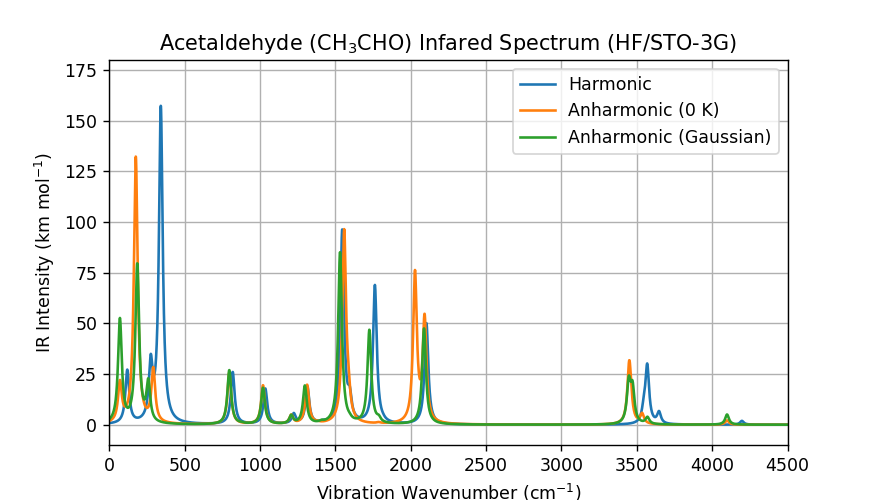

In [78]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.grid()

x = np.arange(0, 4500, 1)
ax.set_xlim(0, 4500)
ax.set_ylim(-10, 180)
ax.plot(x, ir_plot(x, 30, fa.freq, IR_inten), label="Harmonic")
ax.plot(x, ir_plot(x, 30, freq_anharm, IR_anharm), label="Anharmonic (0 K)")
# ax.plot(x, ir_plot(x, 30, freq_anharm, IRT_anharm), label="Anharmonic (2500 K)")
ax.plot(x, ir_plot(x, 30, freq_anharm_gau, IR_anharm_gau), label="Anharmonic (Gaussian)")
ax.set_ylabel("Molar Absorption Coefficient (L mol$^{-1}$ cm$^{-1}$)")
ax.set_xlabel("Vibration Wavenumber (cm$^{-1}$)")
ax.set_title("Acetaldehyde ($\mathsf{CH_3CHO}$) Infared Spectrum (HF/STO-3G)")
ax.legend(loc="upper right")

ax.set_ylabel("IR Intensity (km mol$^{-1}$)")
ax.legend(loc="upper right")

## 文档补充信息

这份文档的一部分内容与颜文杰有较多讨论，与申同昊有一部分讨论。我也算是对非谐矫正有些好奇，于是尝试搞了一下。

[^Barone.JCP.2005]: Anharmonic Vibrational Properties by a fully automated second-order perturbative approach, V. Barone, *J. Chem. Phys.* **2005**, *122*, 014108, doi: [10.1063/1.1824881](https://doi.org/10.1063/1.1824881).

[^Miller.CPL.1990]: Ab initio calculation of anharmonic constants for a transition state, with application to semiclassical transition state tunneling probabilities, W. H. Miller, R. Hernandez, N. C. Handy, D. Jayatilaka, A. Willetts, *Chem. Phys. Lett.* **1990**, *172*, 62-68, doi: [10.1016/0009-2614(90)87217-F](https://doi.org/10.1016/0009-2614(90)87217-F).

[^Gauss.JCP.2008]: Quantitative prediction of gas-phase <sup>19</sup>F nuclear magnetic shielding constants, M. E. Harding, M. Lenhart, A. A. Auer, J. Gauss, *J. Chem. Phys.* **2008**, *128*, 244111, doi: [10.1063/1.2943145](https://doi.org/10.1063/1.2943145).

[^Bloino.JCP.2012]: A second-order perturbation theory route to vibrational averages and transition properties of molecules: General formulation and application to infrared and vibrational circular dichroism spectroscopies, J. Bloino, V. Barone, *J. Chem. Phys.* **2012**, *136*, 124108, doi: [10.1063/1.3695210](https://doi.org/10.1063/1.3695210).

[^Bloino.JPCA.2015]: A VPT2 Route to Near-Infrared Spectroscopy: The Role of Mechanical and Electrical Anharmonicity, *J. Phys. Chem. A* **2015**, *119*, 5269-5287, doi: [10.1021/jp509985u](https://doi.org/10.1021/jp509985u).